In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from math import ceil
import scipy

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import clone

# Helper methods

In [94]:
happiness_dir_name = 'happiness'
holocaust_dir_name = 'holocaust'
horror_dir_name = 'horror'
nature_dir_name = 'nature'
plank_dir_name = 'plank'
relax_dir_name = 'relax'
rest_dir_name = 'rest'
rollercoaster_dir_name = 'rollercoaster'

In [95]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

In [96]:
def cherchez(estimator, param_grid, search, x_train, y_train, folds):
  if search=="random":
    clf = RandomizedSearchCV(
                estimator=estimator,
                param_distributions=param_grid,
                n_iter=10,
                n_jobs=-1,
                cv=folds,
                verbose=2,
                random_state=1,
                return_train_score=True
            )
  elif search == "grid":
    clf = GridSearchCV(
                estimator=estimator,
                param_grid=param_grid,
                n_jobs=-1,
                cv=folds,
                verbose=2,
                return_train_score=True
            )
  else:
    raise ValueError("Random or grid search?")
    return 0
        
    # Fit the model
  clf.fit(X=x_train, y=y_train)
    
  return clf  

In [97]:
def convolve_filter(X_arr, filter_size=10):
  for i in range(X_arr.shape[1]):
    X_arr[:, i] = np.convolve(X_arr[:,i], np.ones(filter_size), 'same') / filter_size
  # X_arr = X_arr/10**6
  return X_arr

# Process input

In [98]:
CONVOLUTION_FILTER_SIZE = 15

In [99]:
# data loading
df_time = pd.read_csv('MEdataset_traditionalClassifiers.csv')
df_time = df_time.drop(['Unnamed: 0'], axis=1)
df_time

,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma,label
0,0.186188,0.035327,0.008678,0.019436,0.012044,0.008582,0.005851,0.004385,happiness
1,0.249095,0.052902,0.012438,0.020675,0.012932,0.009894,0.006477,0.004649,happiness
2,0.318001,0.056180,0.012778,0.020908,0.013623,0.010612,0.006561,0.004672,happiness
3,0.383998,0.062920,0.018410,0.021940,0.014660,0.010950,0.006762,0.004787,happiness
4,0.498938,0.065180,0.019788,0.022802,0.017354,0.012368,0.007395,0.004895,happiness
...,...,...,...,...,...,...,...,...,...
21607,1.397923,0.288205,0.090126,0.060092,0.074694,0.043253,0.059317,0.020761,rollercoaster
21608,1.236768,0.254862,0.048056,0.038609,0.021826,0.032543,0.050653,0.013683,rollercoaster
21609,0.933506,0.205315,0.038986,0.026887,0.014375,0.025006,0.036829,0.008533,rollercoaster
21610,0.834086,0.185413,0.036705,0.025343,0.012945,0.023059,0.035161,0.007757,rollercoaster


In [100]:
# split to X-input, y-output
X = df_time.drop(['label'], axis=1)
y = df_time['label']

In [101]:
# data smoothing, scaling
X_arr = X.to_numpy()
X_arr_proc = convolve_filter(X_arr, filter_size=CONVOLUTION_FILTER_SIZE)

In [102]:
# labels mapping words to numbers
labels_mapping = {
                  happiness_dir_name: 0, 
                  holocaust_dir_name: 1, 
                  horror_dir_name: 2, 
                  plank_dir_name: 3, 
                  relax_dir_name: 4, 
                  rest_dir_name: 5, 
                  rollercoaster_dir_name: 6, 
                  nature_dir_name: 7
                }
y_mapped = y.replace(labels_mapping)
y_mapped = y_mapped.to_numpy()
print(f"8 class labels: {np.unique(y_mapped, return_counts=True)}")

labels_mapping_binary = {
                  happiness_dir_name: 1, #0
                  horror_dir_name: 1, #2
                  plank_dir_name: 1,  #3
                  rollercoaster_dir_name: 1,  #6

                  holocaust_dir_name: 0,  #1
                  relax_dir_name: 0,  #4 
                  rest_dir_name: 0, #5
                  nature_dir_name: 0  #7
                }
y_binary = y.replace(labels_mapping_binary)
y_binary = y_binary.to_numpy()
print(f"binary labels: {np.unique(y_binary, return_counts=True)}")

8 class labels: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([3551, 2467, 2524, 3051, 2376, 2178, 1955, 3510]))
binary labels: (array([0, 1]), array([10531, 11081]))


In [103]:
# update dataframe and reduce number of classes
df_time_proc = pd.DataFrame(data=X_arr_proc, columns=df_time.drop(['label'], axis=1).columns)
df_time['label_binary'] = df_time['label'].replace(labels_mapping_binary)
df_time['label_8class'] = df_time['label'].replace(labels_mapping)

df_time_proc['label_binary'] = df_time['label_binary']
df_time_proc['label_8class'] = df_time['label_8class']

df_time_proc_smaller = df_time_proc[
                                    (df_time_proc['label_8class']!=3) & 
                                    (df_time_proc['label_8class']!=5) & 
                                    (df_time_proc['label_8class']!=6) & 
                                    (df_time_proc['label_8class']!=7)]
df_time_proc_smaller.reset_index(drop=True, inplace=True)
X_arr_proc = X_arr_proc[(y_mapped != 3) & (y_mapped != 5) & (y_mapped != 6) & (y_mapped != 7)]
y_binary = y_binary[(y_mapped != 3) & (y_mapped != 5) & (y_mapped != 6) & (y_mapped != 7)]
print(f"X: {len(X_arr_proc)}, y: {len(y_binary)}")
df_time_proc_smaller

X: 10918, y: 10918


,delta,theta,lowAlpha,highAlpha,lowBeta,highBeta,lowGamma,highGamma,label_binary,label_8class
0,0.211987,0.030380,0.008651,0.011633,0.007956,0.005809,0.003514,0.002421,1,0
1,0.244752,0.034697,0.010143,0.012968,0.008808,0.006882,0.003930,0.002600,1,0
2,0.287725,0.040103,0.011774,0.014431,0.012449,0.009104,0.004351,0.002949,1,0
3,0.336099,0.046753,0.013971,0.016310,0.016598,0.011647,0.004796,0.003227,1,0
4,0.382594,0.053203,0.015963,0.018336,0.021293,0.014148,0.005233,0.003494,1,0
...,...,...,...,...,...,...,...,...,...,...
10913,0.686399,0.277750,0.065933,0.056277,0.034375,0.036761,0.046268,0.017782,0,4
10914,0.642010,0.237810,0.058172,0.050454,0.031627,0.033588,0.040694,0.015936,0,4
10915,0.603970,0.209367,0.052590,0.045573,0.029197,0.030488,0.035300,0.014507,0,4
10916,0.566349,0.180999,0.047119,0.040663,0.026807,0.027547,0.029951,0.013059,0,4


In [104]:
df_time_proc_smaller['label_8class'].value_counts()

0    3551
2    2524
1    2467
4    2376
Name: label_8class, dtype: int64

In [105]:
np.unique(y_binary, return_counts=True)

(array([0, 1]), array([4843, 6075]))

In [106]:
# subsample to have equal number of samples in each class
X_arr_proc_sub, y_binary_sub = balanced_subsample(X_arr_proc, y_binary)
print(f"Each class number: {np.unique(y_binary_sub, return_counts=True)}")
print(f"Total samples: {len(X_arr_proc_sub)}")

Each class number: (array([0., 1.]), array([4843, 4843]))
Total samples: 9686


In [107]:
# split this to balanced training/test sets, and get indexes of chosen samples
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_idx, test_idx in stratSplit.split(X_arr_proc_sub, y_binary_sub):
    X_train=X_arr_proc_sub[train_idx]
    y_train=y_binary_sub[train_idx]
    X_test=X_arr_proc_sub[test_idx]
    y_test=y_binary_sub[test_idx]

print(f"X train shape: {X_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"y train: {X_train.shape}   y test: {y_test.shape}")
print(f"Train balance: {np.unique(y_train, return_counts=True)}")
print(f"Test balance: {np.unique(y_test, return_counts=True)}")

X train shape: (7748, 8)
X test shape: (1938, 8)
y train: (7748, 8)   y test: (1938,)
Train balance: (array([0., 1.]), array([3874, 3874]))
Test balance: (array([0., 1.]), array([969, 969]))


# Support Vector Machine

In [120]:
CV_FOLDS = 5

In [121]:
svc = SVC(C=1.0, kernel='rbf', degree=3, random_state=0) # basic settings
svc.fit(X_train, y_train)
cm_svm = confusion_matrix(y_true=y_test, y_pred=svc.predict(X_test))
print(classification_report(y_true=y_test, y_pred=svc.predict(X_test)))
print(f"Accuracy score: {accuracy_score(y_test, svc.predict(X_test))}")

              precision    recall  f1-score   support

         0.0       0.56      0.68      0.62       969
         1.0       0.60      0.47      0.52       969

    accuracy                           0.57      1938
   macro avg       0.58      0.57      0.57      1938
weighted avg       0.58      0.57      0.57      1938

Accuracy score: 0.5748194014447885


In [122]:
C_range = [pow(10, n) for n in range(-4, 4)]
degree_range = [n for n in range(1, 4)]
svm_dist = {
    "C": C_range,
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": degree_range,
    "gamma": ["scale", "auto"]
}
svm_random = cherchez(SVC(), svm_dist, "random", X_train, y_train, folds=CV_FOLDS)
svm_random.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


SVC(C=10, degree=1)

In [123]:
acc = accuracy_score(y_true=y_test, y_pred=svm_random.predict(X_test))
cm_svm_cv = confusion_matrix(y_true=y_test, y_pred=svm_random.predict(X_test))
print("**Random search results**")
print("Best training accuracy:\t", svm_random.best_score_)
print("Test accuracy:\t", acc)

**Random search results**
Best training accuracy:	 0.5907330848205918
Test accuracy:	 0.5949432404540763


# k-Nearest Neighbours

In [110]:
knn = KNeighborsClassifier()  # basic settings
knn.fit(X_train, y_train)
cm_knn = confusion_matrix(y_true=y_test, y_pred=knn.predict(X_test))
print(classification_report(y_true=y_test, y_pred=knn.predict(X_test)))
print(f"Accuracy score: {accuracy_score(y_test, knn.predict(X_test))}")

              precision    recall  f1-score   support

         0.0       0.75      0.78      0.76       969
         1.0       0.77      0.75      0.76       969

    accuracy                           0.76      1938
   macro avg       0.76      0.76      0.76      1938
weighted avg       0.76      0.76      0.76      1938

Accuracy score: 0.7610939112487101


In [112]:
knn_dist = {
    "n_neighbors": scipy.stats.randint(1,33),
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "leaf_size": scipy.stats.randint(1,1000),
    "p": [1,2]
}
knn_random = cherchez(KNeighborsClassifier(), knn_dist, "random", X_train, y_train, folds=CV_FOLDS)
knn_random.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


KNeighborsClassifier(algorithm='brute', leaf_size=314, n_neighbors=2, p=1)

In [113]:
acc = accuracy_score(y_true=y_test, y_pred=knn_random.predict(X_test))
cm_knn_cv = confusion_matrix(y_true=y_test, y_pred=knn_random.predict(X_test))
print("**Random search results**")
print("Best training accuracy:\t", knn_random.best_score_)
print("Test accuracy:\t", acc)

**Random search results**
Best training accuracy:	 0.8162102501093317
Test accuracy:	 0.8219814241486069


# Decision Tree

In [114]:
tree = DecisionTreeClassifier() # basic settings
tree.fit(X_train, y_train)
cm = confusion_matrix(y_true=y_test, y_pred=tree.predict(X_test))
print(classification_report(y_true=y_test, y_pred=tree.predict(X_test)))
print(f"Accuracy score: {accuracy_score(y_test, tree.predict(X_test))}")

              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84       969
         1.0       0.84      0.84      0.84       969

    accuracy                           0.84      1938
   macro avg       0.84      0.84      0.84      1938
weighted avg       0.84      0.84      0.84      1938

Accuracy score: 0.8390092879256966


In [115]:
dtc_param = {
    "max_depth": [None, 2, 3, 5, 10, 20],
    "min_samples_split": [2],
    "min_samples_leaf": [1, 5, 10, 20, 50, 100],
    "min_weight_fraction_leaf": [0.],
    "max_features": [None],
    "random_state": [4],
    "max_leaf_nodes": [None], # None = infinity or int,
    'criterion': ["gini", "entropy"]
}

dtc_grid = cherchez(DecisionTreeClassifier(), dtc_param, "grid", X_train, y_train, folds=CV_FOLDS)
dtc_grid.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


DecisionTreeClassifier(random_state=4)

In [116]:
acc = accuracy_score(y_true=y_test, y_pred=dtc_grid.predict(X_test))
cfmatrix_rand = confusion_matrix(y_true=y_test, y_pred=dtc_grid.predict(X_test))
print("**Random search results**")
print("Best training accuracy:\t", dtc_grid.best_score_)
print("Test accuracy:\t", acc)

**Random search results**
Best training accuracy:	 0.8218901684749786
Test accuracy:	 0.8369453044375645


## Heatmaps

In [117]:
LABELS = ["calm", "alert"]

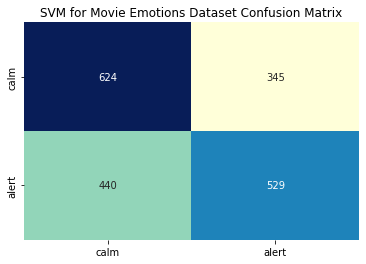

In [124]:
sns.heatmap(cm_svm_cv, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt="d", cbar=False, cmap="YlGnBu") # y-axis: true label, x-axis: predicted label
plt.title("SVM for Movie Emotions Dataset Confusion Matrix")
plt.show()

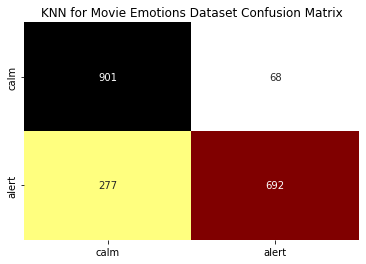

In [118]:
labels = ["calm", "alert"]
sns.heatmap(cm_knn_cv, annot=True, xticklabels=labels, yticklabels=labels, fmt="d", cbar=False, cmap="afmhot_r")
plt.title("KNN for Movie Emotions Dataset Confusion Matrix")
plt.show()

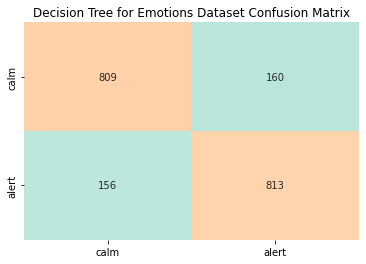

In [119]:
sns.heatmap(cfmatrix_rand, annot=True, xticklabels=labels, yticklabels=labels, fmt="d", cbar=False, cmap="icefire")
plt.title("Decision Tree for Emotions Dataset Confusion Matrix")
plt.show()